In [31]:
import numpy as np;
import csv
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold 
import math
#import pydot
#import graphviz
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000})
import statistics as stcs

import sklearn as sk
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,scale,MinMaxScaler
from scipy.stats import uniform,expon
from sklearn.model_selection import cross_val_score

In [77]:
np.random.seed(1001)
data = pd.read_csv('NMC_numerical_new.csv')

def data_split (data, test_ratio):
    np.random.seed(1001)
    df = pd.DataFrame(data)
    total_row = df.shape[0]
    test_row = round(total_row *test_ratio)
    train_row = total_row -test_row
    indices =np.random.permutation(total_row)
    train_indx, test_idx =indices[:train_row], indices[train_row:]
    train,test = df.iloc[train_indx,:], df.iloc[test_idx,:]
    X_test = test.iloc[:,0:20]
    y_test = test.iloc [:,21]
    X_train = train.iloc[:,0:20]
    y_train = train.iloc [:,21]
    return train,X_train,y_train,X_test,y_test
    
train,X_train,y_train,X_test,y_test = data_split(data,0.2)


# 10-fold cross validation
kf = KFold(n_splits=5,random_state =1001,shuffle= True)


In [33]:
len(y_train)/5

26.8

In [90]:
rand_para = {'n_estimators':range(300,3801),'max_features':range(6,11),
             'max_depth': range(9,15)}
reg=RandomForestRegressor(random_state = 1001,min_samples_leaf =1,min_samples_split=2)

n_iteration = 10000
Scoring = ['explained_variance','neg_mean_squared_error',"r2"]
random_search = RandomizedSearchCV(reg,param_distributions=rand_para,cv =5,
                                   error_score=0,random_state=1001,return_train_score=True,n_jobs=-1,n_iter=n_iteration,verbose=10,refit=True)

#scoring=Scoring,

random_search.fit(X_train,y_train)

#y_predict=random_search.predict(X_test)
#math.sqrt(stcs.mean((y_predict-y_test)**2))

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

KeyboardInterrupt: 

In [78]:
RF_model_IC =RandomForestRegressor(n_estimators=513,max_features=11,min_samples_split=5,
             max_depth=7,min_samples_leaf=1,random_state = 1001)

train_results =[]
train_results_name =['Experimental','Predicted','RMSE']


for train_index, test_index in kf.split(X_train):
    #print("Train:", train_index, "Validation:", test_index)
    X_training, X_validate = X_train.iloc[train_index], X_train.iloc[test_index]
    y_training, y_validate = y_train.iloc[train_index], y_train.iloc[test_index]
    np.random.seed(1001)
    RF_model_IC.fit(X_training,y_training)
    y_train_predicted = RF_model_IC.predict(X_validate)
    number_ob =X_validate.shape[0]
    squared_deviations=(y_train_predicted-y_validate)**2
    RMSE=math.sqrt(squared_deviations.sum()/number_ob)
    train_results.append([y_validate,y_train_predicted,RMSE])


In [79]:
Train_results = pd.DataFrame (train_results,columns=train_results_name)

predict_results = pd.DataFrame (Train_results.iloc[:,1])

np.average(Train_results['RMSE'])

21.857358950721476

In [80]:
np.random.seed(1001)
RF_model_IC.fit(X_train,y_train)
y_predict = RF_model_IC.predict(X_test)
math.sqrt(stcs.mean((y_predict-y_test)**2))

19.253009375663446

In [81]:
total = sum((y_test-stcs.mean(y_test))**2)
unexplained = sum((y_test-y_predict)**2)

R_square_test = 1-(unexplained/total)

In [82]:
R_square_test

0.41992317943875

In [83]:
Experimental =[]
Predicted =[]

for i in range(Train_results.shape[0]):
    Ex=Train_results.iloc[i,0].to_string(index=False)
    Pred = pd.DataFrame(Train_results.iloc[i,1]).to_string(index_names=False,index=False,header=False)
    Ex_num = Ex.split("\n ")
    Pre = Pred.split("\n ")
    a = np.array([float(i) for i in Ex_num])
    b = np.array([float(c) for c in Pre])
    Experimental.extend(a)
    Predicted.extend(b)


In [65]:
Ex= pd.DataFrame(Experimental)

Pred = pd.DataFrame(Predicted)

results =pd.concat([Ex,Pred],axis=1,sort=False)

In [66]:
results.to_csv('RF-IC-TRAIN-EXPERIMENT-PREDICTED.csv')

In [67]:
Pre_y_test = pd.DataFrame(y_predict,index=None)
Ex_y_test =pd.DataFrame(y_test)
Ex_y_test.reset_index(drop=True, inplace=True)
results_test =pd.concat([Ex_y_test,Pre_y_test],axis=1,join='inner')

In [68]:
results_test.to_csv('RF-IC-TEST--EXPERIMENT-PREDICTED.csv')

In [69]:
len(data)

168

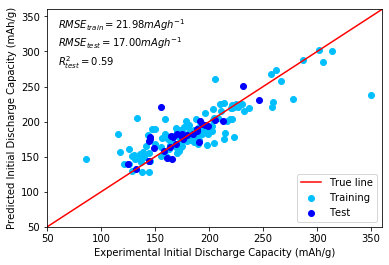

In [74]:
import numpy
import matplotlib.axes as ax
import matplotlib.pyplot as plt

x= y_test
y=y_predict 

plt.axis([50,360,50,360])
plt.scatter(y=results.iloc[:,1],x=results.iloc[:,0],c='deepskyblue',label='Training')
plt.scatter(x,y, c='blue',label='Test')
plt.plot([50,360],[50,360],label ='True line',c='red')
plt.legend(loc='lower right')
#plt.title(label='SVM-EC-Results-Plot')

plt.xlabel(r'Experimental Initial Discharge Capacity (mAh/g)')
plt.ylabel(r'Predicted Initial Discharge Capacity (mAh/g)')
plt.text(60,280,r'$RMSE_{train}=21.98 mAgh^{-1}$'+'\n'+r'$RMSE_{test}=17.00 mAgh^{-1}$' +"\n"+ '$R^2_{test}=0.59$')

#$50^{th}$ Cycle
plt.savefig('RF-IC-Predicted-vs-test.png',dpi=600)
plt.show()



# Variable Importance

Feature: 0, Score: 0.10214
Feature: 1, Score: 0.02826
Feature: 2, Score: 0.04222
Feature: 3, Score: 0.02285
Feature: 4, Score: 0.05177
Feature: 5, Score: 0.02335
Feature: 6, Score: 0.02737
Feature: 7, Score: 0.02766
Feature: 8, Score: 0.04491
Feature: 9, Score: 0.18276
Feature: 10, Score: 0.15528
Feature: 11, Score: 0.01256
Feature: 12, Score: 0.06239
Feature: 13, Score: 0.01214
Feature: 14, Score: 0.03556
Feature: 15, Score: 0.00621
Feature: 16, Score: 0.04678
Feature: 17, Score: 0.08559
Feature: 18, Score: 0.01561
Feature: 19, Score: 0.01459


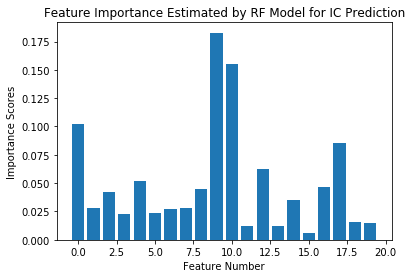

In [84]:

# get importance
importance = RF_model_IC.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)

plt.title(label='Feature Importance Estimated by RF Model for IC Prediction')
plt.xlabel(r'Feature Number')
plt.ylabel(r'Importance Scores')

#plt.savefig('RF-IC-Feature_IMPORTANCE.png',dpi=600)
plt.show()

In [32]:
importance

array([0.09460253, 0.03830587, 0.04604882, 0.02777192, 0.02658629,
       0.02862865, 0.03653709, 0.03279519, 0.05587573, 0.1869717 ,
       0.14888042, 0.01576508, 0.06960857, 0.0153785 , 0.03534778,
       0.00865769, 0.01996437, 0.08230101, 0.01450274, 0.01547006])